# Import and map netcdf data

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc

### Import data from netcdf file

For this example, we will read 500-hPa geopotential height data from a netCDF file of daily ERA5 reanalysis (0.75 deg, 1979-2017).

In [4]:
# Set path to data file
datadir = "/Users/tessamontini/Google_Drive/DATA/"
fname = "era5_zg_500_day_1979-2017.nc"
filepath = datadir + fname
print(filepath)

# Open netCDF file object
f = nc.Dataset(filepath, 'r')

# Print info about file contents and metadata
print(f)

/Users/tessamontini/Google_Drive/DATA/era5_katelyn/era5_zg_500_day_1979-2017.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    CDI: Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    history: Thu Jul 25 13:15:08 2019: cdo daymean concat.nc era5_zg_500_day_1979-2017.nc
Thu Jul 25 13:14:07 2019: cdo divc,9.80665 concat.nc tmp2.nc
Thu Jul 25 13:14:07 2019: ncrename -O -v z,zg concat.nc
    institution: European Centre for Medium-Range Weather Forecasts
    NCO: 4.6.7
    nco_openmp_thread_number: 1
    title: ERA5 Reanalysis
    frequency: day
    CDO: Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/cdo)
    dimensions(sizes): longitude(94), latitude(54), time(14245), bnds(2)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float64 time(time), float64 time_bnds(time,bnds), float64 zg(time,latitude,longitude)
    groups: 



In [14]:
# Retrieve data variables
geop500 = f.variables['zg'][:] # [:] syntax stores data in np arrays

# Inspect your data
print(geop500.shape)  # print dim sizes
print(geop500[:,0,0])        # print some values

# Retrieve coordinate variables
lons = f.variables['longitude'][:]
lats = f.variables['latitude'][:]
time = f.variables['time']

print(lons)

(14245, 54, 94)
[5304.69414551 5370.48821694 5458.78595418 ... 5323.82683105 5282.56357029
 5226.99012305]
[-160.   -159.25 -158.5  -157.75 -157.   -156.25 -155.5  -154.75 -154.
 -153.25 -152.5  -151.75 -151.   -150.25 -149.5  -148.75 -148.   -147.25
 -146.5  -145.75 -145.   -144.25 -143.5  -142.75 -142.   -141.25 -140.5
 -139.75 -139.   -138.25 -137.5  -136.75 -136.   -135.25 -134.5  -133.75
 -133.   -132.25 -131.5  -130.75 -130.   -129.25 -128.5  -127.75 -127.
 -126.25 -125.5  -124.75 -124.   -123.25 -122.5  -121.75 -121.   -120.25
 -119.5  -118.75 -118.   -117.25 -116.5  -115.75 -115.   -114.25 -113.5
 -112.75 -112.   -111.25 -110.5  -109.75 -109.   -108.25 -107.5  -106.75
 -106.   -105.25 -104.5  -103.75 -103.   -102.25 -101.5  -100.75 -100.
  -99.25  -98.5   -97.75  -97.    -96.25  -95.5   -94.75  -94.    -93.25
  -92.5   -91.75  -91.    -90.25]


### Time coordinate handling

Two options for making a datetime array:  

1) Method 1: Read in times from netcdf file and convert it to a datetime object (you will also need to read in the time.units attribute).

In [8]:
# Read in times and time units att from nc file
times = f.variables['time']
time_units = f.variables['time'].units    
print(time_units)

# Convert to datetime object
dates_nc = nc.num2date(times[:], time_units)  
print(dates_nc)

hours since 1900-01-01 00:00:00.0
[datetime.datetime(1979, 1, 1, 9, 0) datetime.datetime(1979, 1, 2, 9, 0)
 datetime.datetime(1979, 1, 3, 9, 0) ...
 datetime.datetime(2017, 12, 29, 9, 0)
 datetime.datetime(2017, 12, 30, 9, 0)
 datetime.datetime(2017, 12, 31, 9, 0)]


2) Method 2: Create a pandas datetime object from scratch (this is what I usually do)

In [9]:
dates_pd = pd.date_range(start='1979-01-01', end='2018-12-01', 
                         freq='D')   # D = daily
print(dates_pd)

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2018-11-22', '2018-11-23', '2018-11-24', '2018-11-25',
               '2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29',
               '2018-11-30', '2018-12-01'],
              dtype='datetime64[ns]', length=14580, freq='D')


## Plotting

Create a filled contour plot of 500-hpa geopotential heights using cartopy.

When plotting with cartopy, you must specify the source coordinates of your data (`datacrs` = _data coordinates_) and the coordinate or projection that you want to plot your data in (`mapcrs` = _map coordinates_). Always use "PlateCarree" if your data are in lat/lon coordinates. See link below for all available projections.

**Plotting resources:**
* [Cartopy projection list](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html#cartopy-projections)
* [Matplotlib colormaps](https://matplotlib.org/tutorials/colors/colormaps.html)

5100.448818105825 5877.307312721831


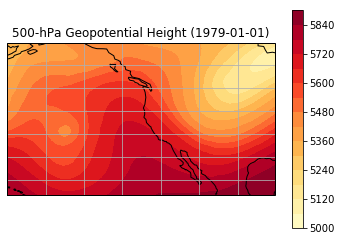

In [21]:
# Data for plotting
data = geop500[0,:,:]   # plot first time step
print(data.min(), data.max())

# Set your data coordinates (input for transform keyword)
datacrs = ccrs.PlateCarree()
# Set the map projection coordinates (input for projection keyword)
mapcrs = ccrs.PlateCarree()

# Create the figure and plot axes (the individual plot)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=mapcrs)

# Add data to plot axes (filled contour plot)
clevs = np.arange(5000,5960,60)  # contour levels (start,stop,step)
cf = ax.contourf(lons, lats, data, transform=datacrs,
                 levels=clevs, cmap='YlOrRd')

# Add colorbar
plt.colorbar(cf)

# Add title
ax.set_title("500-hPa Geopotential Height (1979-01-01)")

# Add plot features
ax.coastlines()
ax.gridlines()

# Option to save figure to png file
plt.savefig('geop500.png')

# Display figure
plt.show()